# 自然言語処理にむけて

画像認識は、もともと画像データが多次元ベクトルで表現されており、
よく似た画像が近いベクトルで表現されるなど、機械学習で処理しやすい前提が整っていました。
一方、自然言語などのテキストは、文字コードが近くても意味が近いわけではありません。
自然言語を機械学習で処理するためには、
テキストの特徴量を多次元ベクトルでうまく表現することが鍵になります。


<img src="https://stg2-cdn.go2senkyo.com/articles/wp-content/uploads/2015/07/0ec9a44365144d96fb771d83b7bcc02e.jpg" width="40%"/> 


最後のまとめとして、
自然言語処理を機械学習で扱う方法を考えていきましょう。

__モジュールの準備__


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
try:
    import japanize_matplotlib #matplotlibの日本語化  
except ModuleNotFoundError:
    !pip install japanize_matplotlib
    import japanize_matplotlib 
sns.set(font="IPAexGothic") #日本語フォント設定


## 形態素解析

言語における意味の基本単位は語 (word) です。まず、語を取り出す方法からみていきましょう。

### 英語と日本語

自然言語処理は、言語の種類によって難しさや扱い方が異なります。

* (英語文) I bought a book 
* (日本語文) 私は本を買った

英語は、空白で区切られたものを語と考えることができます。
したがって、Python の標準文字列ライブラリだけで、簡単に語を取り出すことができます。

__英語の字句解析__

In [2]:
s = "I bought a book"
s.split()

['I', 'bought', 'a', 'book']

日本語では、まず語の区切りを判定する必要があります。
しかし、この語の区切りを判定するのが**かなりの難処理**です。

<div class="alert alert-info">

**形態素解析ツール（ライブラリ）**

日本語文から、語の区切りを決定するツール（ライブラリ）

</div>



### spaCy/GINZA

spaCy は、Explosion AI 社の開発するオープンソースの自然言語処理ライブラリです。2019 年に、 リクルート AI 研究所と国立言語研究所の研究成果である [GiNZA](https://megagonlabs.github.io/ginza/) が登場し、実用的な日本語処理が手軽に利用できるようになりました。

まずは、GiNZA の導入から始めましょう。`pip install ginza` を入力するだけで、 形態素解析も含め、自然言語処理に必要なライブラリがまとめてインストールされます。

```
!pip install ginza
import pkg_resources, imp
imp.reload(pkg_resources)
```

SpaCy/GINZAは、各種自然言語処理をパイプライン化したツールになっています。パイプラインを調整することで、最終的な処理を切り替えることができます。

単純に形態素解析したいときは、次の通り、使います。


In [3]:
import spacy
nlp = spacy.load('ja_ginza') 

doc = nlp("私は本を買った") #形態素解析
for word in doc:
    print(word.i, word.orth_, word.lemma_, word.pos_, word.tag_)

0 私 私 PRON 代名詞
1 は は ADP 助詞-係助詞
2 本 本 NOUN 名詞-普通名詞-一般
3 を を ADP 助詞-格助詞
4 買っ 買う VERB 動詞-一般
5 た た AUX 助動詞


|プロパティ|情報|
|--|--|
|`orth_`|入力語|
|`lemma_`|原型|
|`pos_`|品詞(Part of Speech)|
|`tag_`|品詞タグ|
|`vector`|単語ベクトル|



日本語文を単語単位に分割する関数`wakachi(s)`を定義しておきましょう。

In [4]:
def wakachi(s):
    doc = nlp(s)
    return [word.lemma_ for word in doc]  # word.lemma_ は標準形

print(wakachi('私は本を買った'))


['私', 'は', '本', 'を', '買う', 'た']


<div class="alert alert-info">

(時間があったら）Let's try

自然言語処理と形態素解析の良い練習問題は、「自然言語処理１００本ノック」にあります。

http://www.cl.ecei.tohoku.ac.jp/nlp100/

Web上には、解説記事がたくさん掲載されていますので、参考にしながら解いてみると実力がつきます。

</div>


## アンケート分析

不動産屋による「まちづくりに関するアンケート」に基づいて、アンケート解析を試していきましょう。
アンケードには、アンケートの回答日、コメント自由記述形式、満足度(5段階評価: 1 不満 - 5 満足)が記載されています。

__データの取り寄せ__

本データは、下山らによる「Python 実践データ分析 100 本ノック」から講義用に編集したものを利用します。

```
!wget https://KuramitsuLab.github.io/data/survey.csv
```

In [5]:
data = pd.read_csv("survey.csv")
data.head() #最初の5行を表示

,日付,コメント,満足度
0,2019/3/11,駅前に若者が集まっている,1
1,2019/2/25,スポーツできる場所があるのが良い,5
2,2019/2/18,子育て支援が嬉しい,5
3,2019/4/9,保育園に入れる（待機児童なし）,4
4,2019/1/6,駅前商店街が寂しい,2


### コメントを眺める 

今まで、様々なデータを扱ってきましたが、
今回のデータは、自由記述形式のテキストが入っているのが特徴です。

まず、アンケート中のコメントの分量を把握してみましょう。
文字数を数えて、新しいカラム(`文字数`)を作って格納します。

In [8]:
data["文字数"] = data["コメント"].str.len()
data.head()

,日付,コメント,満足度,文字数
0,2019/3/11,駅前に若者が集まっている,1,12
1,2019/2/25,スポーツできる場所があるのが良い,5,16
2,2019/2/18,子育て支援が嬉しい,5,9
3,2019/4/9,保育園に入れる（待機児童なし）,4,15
4,2019/1/6,駅前商店街が寂しい,2,9


(array([12., 24., 22., 10.,  6.,  6.,  5.,  0.,  0.,  1.]),
 array([ 4. ,  8.6, 13.2, 17.8, 22.4, 27. , 31.6, 36.2, 40.8, 45.4, 50. ]),
 <BarContainer object of 10 artists>)

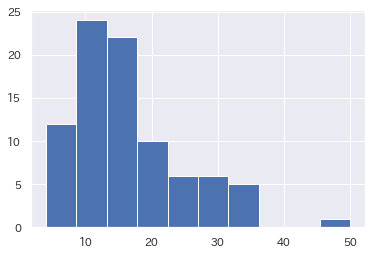

In [7]:
plt.hist(data["文字数"])

以上に長いコメントがありますね。

__コメントの長さ順に並べ変えてみる__

In [9]:
data.sort_values(by="文字数")

,日付,コメント,満足度,文字数
41,2019/2/25,特になし,3,4
69,2019/1/4,特になし,2,4
25,2019/1/21,道が綺麗,4,4
18,2019/3/15,夜道が暗い,1,5
19,2019/2/20,ゴミ処理が楽,4,6
...,...,...,...,...
62,2019/3/19,アンケートをちゃんと確認して街づくりに反映してくれている姿勢が良い,5,33
56,2019/4/13,歩行者用信号が変わるのが早い。老人や子供の事を考えて設定してほしい,2,33
44,2019/2/28,信号のない交差点が近くにあり事故が起きそうで怖い、信号を付けて欲しい。,1,35
39,2019/3/11,変なおじさんに声を掛けられた事がある。警察の巡回をもっと強化してほしい,1,35


### 単語レベルの解析

コメントから単語を抽出して、どのような単語が使われているか調べてみましょう。

* 標準形変換: 活用のある単語（例. 「買った」）は、買うのように標準形に変換する
* [ストップワード除外](https://mieruca-ai.com/ai/nlp-stopwords/#toc_2-1): 解析の精度を上げるために不要な記号や単語を取り除く

ここでは、動詞、形容詞、名詞だけに着目してみます。

In [10]:
words = []
for text in data["コメント"]:
    doc = nlp(text)
    for word in doc:
        # 動詞(VERB), 名詞(NOUN), 形容詞(ADJ)のみ抽出
        if word.pos_ == 'VERB' or word.pos_ == 'NOUN' or word.pos_ == 'ADJ':
            words.append(word.lemma_)
print(len(words))
print(words[:30]) #先頭30語だけ

375
['駅前', '若者', '集まる', 'スポーツ', '場所', 'ある', '良い', '子育て', '支援', '嬉しい', '保育園', '入れる', '待機児童', 'なし', '駅前', '商店街', '寂しい', '生活', '便利', '遊ぶ', '場所', 'ない', '遊ぶ', '場所', 'ない', '商業', '施設', '出来る', '欲しい', '病院']


これで、コメント文の中で用いられている名詞と動詞をすべて取り出すことができました。
しかし、まだどれの単語が重要なのかわかりません。各単語の出現頻度を調べてみましょう。

In [11]:
pd.DataFrame({"words":words}).value_counts()


words
欲しい      15
ほしい      14
少ない       7
駅前        7
良い        6
         ..
大丈夫       1
奇麗        1
姿勢        1
子ども       1
高齢者       1
Length: 228, dtype: int64

### （寄り道）単語頻度の視覚化

ワードクラウドは、テキストデータを視覚的に表現する方法です。ちょっと寄り道をして表示してみましょう。

まず、日本語フォントをインストールしておきます。（これがないと文字化けします。）

__Colab上でのIPA日本語フォントのインストール__
```
!apt-get -y install fonts-ipafont-gothic
```


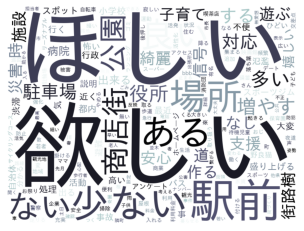

In [18]:
## !pip install wordcloud

from wordcloud import WordCloud
fpath = '/usr/share/fonts/truetype/fonts-japanese-gothic.ttf'
#fpath = 'fonts-japanese-gothic.ttf'
word_chain = ' '.join(words)

model = WordCloud(width=800, height=600, background_color='white', colormap='bone', font_path=fpath)
W = model.generate(' '.join(words))

plt.imshow(W)
plt.axis('off')
plt.show()

これで不動産の満足度に影響を与えているキーワードが見えてきました。しかし、まだどのキーワードがプラスの評価なのか、マイナスの評価なのかわかりません。

<div class="alert alert-info">

Let's try

満足度の高いキーワードを抽出してみよう

</div>

### 満足度の高いキーワード

今回のアンケート調査の素晴らしいことは、不動産の満足度が 5 段階評価で回答されている点です。
各キーワードとこの5段階評価を紐付けてみると、キーワードの満足度が見えて来るかもしれません。 

コメント内の単語と満足度をペアにして取り出してみます。


In [19]:
words = []
scores = []
for text, score in zip(data["コメント"], data["満足度"]):
    doc = nlp(text)
    for word in doc:
        if word.pos_ in ['VERB', 'NOUN', 'ADJ']:
            words.append(word.lemma_)
            scores.append(score)
print(words[:30])
print(scores[:30])

['駅前', '若者', '集まる', 'スポーツ', '場所', 'ある', '良い', '子育て', '支援', '嬉しい', '保育園', '入れる', '待機児童', 'なし', '駅前', '商店街', '寂しい', '生活', '便利', '遊ぶ', '場所', 'ない', '遊ぶ', '場所', 'ない', '商業', '施設', '出来る', '欲しい', '病院']
[1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 4]


Pandas を使って表データにまとめておきましょう。`出現数`1回のカラムを作って、`groupby`してみましょう。満足度は平均値をとることにします。

In [20]:
keyword = pd.DataFrame({"キーワード": words, "満足度": scores, "出現数": [1]*len(words)})
keyword.groupby('キーワード').agg({'満足度': np.mean, '出現数': sum}).sort_values(by='出現数')

,満足度,出現数
キーワード,,
bbb,2.000000,1
暗い,1.000000,1
暮らせる,5.000000,1
最高,5.000000,1
有名,3.000000,1
...,...,...
良い,4.833333,6
少ない,1.142857,7
駅前,1.428571,7


<div class="alert alert-info">

Let's try

満足度の高いキーワードと満足度の低いキーワードのトップ 5を出してみよう

</div>

今回の分析は、出現頻度のあまりに低い単語を除外した方が良いです。このように、データサイエ ンティスト(分析者)のセンスで、結果は少し変わります。


<div class="alert alert-info">

極性辞書とセンティメント解析

極性辞書は、ある単語が一般的にネガティブなのか、ポジティブなのかを、-1（ネガティブ）から1（ポジティブ）までのスコアの形で表現したものです。

* [日本語評価極性辞書](http://www.cl.ecei.tohoku.ac.jp/Open%20Resources_Japanese%20Sentiment%20Polarity%20Dictionary.html)：東北大の乾・岡崎研究室が公開
* [単語感情極性対応表](http://www.lr.pi.titech.ac.jp/~takamura/pndic_ja.html)：東工大の高村教授が公開

センティメント分析などに便利です。（今回の満足を極性辞書と比較してみましょう。）

</div>


## 文章のベクトル化

次は、いよいよ文章のベクトル化を考えていきます。

ポイントは、意味や内容が似ている文が近くなるようにベクトル化することです。
もともと、類似文章検索として研究されてきました技術になります。

まず、準備として、`わかち書き`されたカラムを作っておきましょう。


In [21]:
data['わかち書き'] = data['コメント'].map(lambda x: ' '.join(wakachi(x)))
data.head()

,日付,コメント,満足度,文字数,わかち書き
0,2019/3/11,駅前に若者が集まっている,1,12,駅前 に 若者 が 集まる て いる
1,2019/2/25,スポーツできる場所があるのが良い,5,16,スポーツ できる 場所 が ある の が 良い
2,2019/2/18,子育て支援が嬉しい,5,9,子育て 支援 が 嬉しい
3,2019/4/9,保育園に入れる（待機児童なし）,4,15,保育園 に 入れる （ 待機児童 なし )
4,2019/1/6,駅前商店街が寂しい,2,9,駅前 商店街 が 寂しい


### BOW

**BOW(Bag of Words)** は最も古典的な文書の特徴量を捉えてベクトル化する手法です。
出現する単語の個数を $N$ とすると、各コメント文は出現した単語には 1 を入れた $N$ 次元のベクトルで表現します。

BOW のポイントは、文章の構造は全て無視し、「どの単語が含まれているか」だけに注目している点です。そして、一旦、コメント文をベクトルで表現できれば、**コサイン類似度 (cosine similarity) **を用いて、類似度を求めることができます。

BOW の原理は、難しくありません。sklearnモジュールの`CountVectorizer`を使って、楽に BOW を求めることができます。ただし、sklearn は、英語圏で開発されたライブラリなので、入力文は英単語のように空白で区 切られているという前提になっています。日本語は、形態素解析を使って前処理して、テキストを空白区切りの形式に変換しておく必要があります。


In [22]:
from sklearn.feature_extraction.text import CountVectorizer
docs = np.array(data['わかち書き'])
model = CountVectorizer()
bags = model.fit_transform(docs)

print(bags.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Pandasで表データとマージして、コメントがどのようにベクトル化されたかみてみましょう。


In [23]:
pd.DataFrame(bags.toarray(),columns=model.get_feature_names(),index=data['コメント']).head()

,bbb,あまり,ある,いる,おじ,お祭り,から,くる,くれる,けど,...,隣町,集まる,電話,頻繁,駅前,駐車場,駐輪場,高い,高速道路,高齢者
コメント,,,,,,,,,,,,,,,,,,,,,
駅前に若者が集まっている,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
スポーツできる場所があるのが良い,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
子育て支援が嬉しい,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
保育園に入れる（待機児童なし）,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
駅前商店街が寂しい,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


BOWは、単語の並びを無視しています。語順を無視すると重要な情報が飛んでしまいそうですが、不思議なことに類似文書検索では、十分精度がでます。

### コサイン類似度

コサイン類似度は、文書ベクトルの類似度を測る尺度としてよく使われます。
ベクトルの向きがどの程度同じ方向を向いているか？という指標で、$-1$～$1$の範囲をとります。

コサイン類似度を数式で記述すると以下のようになります。

$$
cos(\mathbf{x}, \mathbf{y}) 
= \frac{\mathbf{x} \cdot \mathbf{y}}{|\mathbf{x}| \cdot|\mathbf{y}|} 
= \frac{\sum_{i=1}^{|V|} x_i y_i}{\sqrt{\sum_{i=1}^{|V|} x_i^2} 
    \cdot \sqrt{\sum_{i=1}^{|V|} y_i^2}}
$$

__なんかそろそろNumPyの方が読みやすくなってきましたね__

In [25]:
def cosine_similarity(x, y):
    return np.dot(x, y)/(np.sqrt(np.dot(x, x))*np.sqrt(np.dot(y, y)))

X = np.array([0.7, 0.5, 0.3,0.1])
Y = np.array([0.8, 0.5, 0.2, 0.222])
print(cosine_similarity(X, Y))


0.9837126278799047


もちろん、skleranモジュールにもコサイン類似度のライブラリは含まれています。
こちらは、ユニバーサル関数バージョンになっているので気をつけましょう。


In [33]:
from sklearn.metrics.pairwise import cosine_similarity
X = np.array([[0.7,0.5,0.3,0.1], [0.1,0.2,0.9,0.9]])
Y = np.array([[0.8, 0.5, 0.2, 0.2], [0.1,0.2,0.9,0.9]])

print(cosine_similarity(X, Y))

[[0.98597181 0.44748449]
 [0.42427716 1.        ]]


実際に、「スポーツできる場所があるのが良い(index=1)」と類似しているコメントを探してみましょう。

In [37]:
def print_sim(index):
    vec = bags.toarray()
    similarity = cosine_similarity(vec[index:index+1], vec)[0]
    top10 = np.argsort(similarity)[::-1][:10]
    for i in top10:
        print(similarity[i], data['コメント'][i])
print_sim(1)

1.0 スポーツできる場所があるのが良い
0.39999999999999997 ランニングとか運動できる場所が多い
0.3162277660168379 サイクリングコースが良い
0.25819888974716115 都内へのアクセスが良い
0.25819888974716115 遊ぶ場所がない
0.22360679774997896 市長が若くて活気がある
0.22360679774997896 消防団が活発で安心できる
0.19999999999999998 子どもが安全に遊ぶ場所がない
0.19999999999999998 歩道が広い道が多くて安心できる
0.19999999999999998 近くに公園があって住みやすい


### TF/IDF

BOW は、単語の出現を見るだけで、重要度を考慮に入れていません。

TF-IDF(Term Frequency-Inverse Document Freequency: 単語頻度-逆文書頻度) は、
よくある一般的な単語と**特徴のある重要な単語**の区別をつける指標です。

__単語 w が n 回現われるとき、TF(Term Frequence)__
$$
TF = \frac{n}{N}
$$

__単語 w を含む文が d 個あるとき、IDF(Inverse Document Frequency)__
$$
IDF = - \log{\frac{d}{D}} = \log{\frac{D}{d}}
$$

TF-IDF は、$TF$ と $IDF$ の積によって求まる。

$$
\mbox{TF-IDF} = \frac{n}{N} \log{\frac{D}{d}}
$$

IDF は一種の一般語フィルタとして働き、多くの文書に出現する語(一般的な語)は重要度が下が り、特定の文書にしか出現しない単語の重要度を上げる役割を果たします。


TF/IDF を用いることで、重要度の重みつけされたベクトルが得られます。（本当は、自分で計算してみましょうとしたいのですが、）sklearn のライブラリを用いてお手軽に計算してみます。


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
# tf-idf

vectorizer = TfidfVectorizer(max_df=0.9) #文書全体の90%以上で出現する単語は無視する
X = vectorizer.fit_transform(data['わかち書き'])
print('feature_names:', vectorizer.get_feature_names())
print('X:')
print(X.toarray())


feature_names: ['bbb', 'あまり', 'ある', 'いる', 'おじ', 'お祭り', 'から', 'くる', 'くれる', 'けど', 'この', 'ごみ', 'さん', 'すぎる', 'する', 'そう', 'たくさん', 'ちゃんと', 'つく', 'できる', 'とき', 'とても', 'どう', 'どのような', 'ない', 'なし', 'なる', 'なん', 'ひどい', 'ほしい', 'ます', 'まち', 'まで', 'もう', 'もっと', 'やすい', 'やめる', 'よう', 'よく', 'よる', 'られる', 'れる', 'アクセス', 'アンケート', 'ゴミ', 'サイクリングコース', 'サポート', 'スポット', 'スポーツ', 'スポーツジム', 'スーパー', 'デート', 'ナンバー', 'バス', 'ホームページ', 'マスコット', 'ママ', 'ランニング', 'リーズナブル', '下さる', '不便', '不安', '不正', '並木', '事件', '事故', '交差点', '他県', '付ける', '企業', '住む', '作る', '便利', '保育園', '信号', '備蓄', '働く', '充実', '先月', '入る', '入れる', '公共', '公園', '公害', '冬場', '凍結', '処理', '出る', '出張所', '出来る', '分かる', '利用', '利用料金', '助かる', '動物園', '反映', '取り扱う', '取る', '商店街', '商業', '喫茶店', '土日', '地域', '場所', '増やす', '変わる', '多い', '夜道', '夜間', '大きい', '大丈夫', '大変', '奇麗', '姿勢', '嬉しい', '子ども', '子供', '子育て', '安全', '安心', '家賃', '寂しい', '対応', '対策', '小学校', '少し', '少ない', '屋根', '巡回', '市長', '広い', '強化', '役所', '待機児童', '後押し', '心配', '怖い', '急行', '投稿', '担当者', '拡幅', '掃除', '掛ける', '支援', '料金', '施設', '早い', '映画館', '暗い

In [39]:
pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names(),index=data['コメント']).head()

,bbb,あまり,ある,いる,おじ,お祭り,から,くる,くれる,けど,...,隣町,集まる,電話,頻繁,駅前,駐車場,駐輪場,高い,高速道路,高齢者
コメント,,,,,,,,,,,,,,,,,,,,,
駅前に若者が集まっている,0.0,0.0,0.000000,0.397231,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.580016,0.0,0.0,0.411545,0.0,0.0,0.0,0.0,0.0
スポーツできる場所があるのが良い,0.0,0.0,0.416521,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
子育て支援が嬉しい,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
保育園に入れる（待機児童なし）,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
駅前商店街が寂しい,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.490089,0.0,0.0,0.0,0.0,0.0


<div class="alert alert-info">
Let's try

TF/IDFの場合の類似コメントを探してみよう。

</div>

### LSA

LSA（潜在的意味解析）では、
トピックという文書と単語の間に存在する抽象的な概念を導入し、各文書の BOW あるいは TF-IDF ベクトルを行とする文書数×単語数の行列を特異値分解（SVD)し、文書数×トピック数に次元削減します。 

__８次元に減らしてみます__


In [40]:
from sklearn.decomposition import TruncatedSVD
np.set_printoptions(suppress=True)
# SVD
svd = TruncatedSVD(n_components=8, n_iter=7, random_state=0)
svd.fit(X.toarray())
X = svd.transform(X.toarray())


In [41]:
pd.DataFrame(X,index=data['コメント'])

,0,1,2,3,4,5,6,7
コメント,,,,,,,,
駅前に若者が集まっている,7.731770e-02,0.055635,0.221337,0.258149,-0.183296,-0.000305,0.136036,-0.064076
スポーツできる場所があるのが良い,9.653416e-02,0.232015,0.242801,-0.275236,0.224877,-0.002571,0.282702,0.372138
子育て支援が嬉しい,1.530323e-01,0.241557,-0.164930,0.098121,0.093775,-0.002967,-0.276363,0.062022
保育園に入れる（待機児童なし）,1.993400e-07,-0.000112,0.000043,0.000067,-0.000063,0.508183,-0.004800,0.000048
駅前商店街が寂しい,1.475882e-01,-0.066456,0.235868,0.196006,-0.265106,0.001276,-0.074943,0.076161
...,...,...,...,...,...,...,...,...
小学校の校庭が芝生なのでとても良い,3.357989e-02,0.109346,0.002445,-0.019058,0.079640,0.002153,0.071718,0.297933
ホームページからアンケートを投稿できるようにしてほしい,2.061109e-01,0.200964,-0.030146,-0.113776,-0.090526,-0.001596,0.202042,0.033840
公園に遊び道具が少なすぎる,1.735468e-01,-0.023439,0.093533,0.130378,-0.037278,0.001100,0.007060,0.216022


では、「スポーツできる場所があるのが良い(index=1)」と類似しているコメントをみてみましょう。

In [44]:
def print_sim(index):
    similarity = cosine_similarity(X[index:index+1], X)[0]
    top10 = np.argsort(similarity)[::-1][:10]
    for i in top10:
        print(similarity[i], data['コメント'][i])
print_sim(1)

0.9999999999999998 スポーツできる場所があるのが良い
0.9704742874252414 ランニングとか運動できる場所が多い
0.9271749843766424 市長が若くて活気がある
0.8850136813887487 消防団が活発で安心できる
0.8794676152538797 歩道が広い道が多くて安心できる
0.8696169842692176 サイクリングコースが良い
0.8678878385469999 冬場、路面凍結で事故が多い、対応できませんか
0.8541713596444912 有名な企業が多い
0.836653242687093 隣町にできたごみ処理施設が心配、公害は大丈夫？
0.8337364715521739 都内へのアクセスが良い


参考資料：
https://www.ogis-ri.co.jp/otc/hiroba/technical/similar-document-search/part1.html


## 単語分散表現

文書中の単語出現数を元に文書ベクトルを紹介してきましたが、最後に単語の持つ意味的な情報を用いる手法として、**単語分散表現**（単語ベクトル）について紹介します。

単語分散表現では、単語を多次元空間上の座標にマッピングすることで、単語同士の類似度を比較したり、加減算したりすることができるようになります。


単語分散表現は、さまざまな方法で求められます。
しかし、2013年にGoogle研究所が発表した Word2Vecが有名です。
これは、「同じ文脈で登場する単語は似た意味を持つ」という分布仮説をベースにして、ニューラルネットワークで計算されます。


### 単語ベクトル

GiNZAは、形態素解析したときに単語ベクトルが`voctor`プロパティで付与されています。

__単語ベクトルを確認してみる__


In [45]:
doc = nlp('スポーツ 良い')
print(doc[0].vector.shape, doc[0].vector) # 「スポーツ」の単語ベクトル
#print(doc[1].vector.shape, doc[1].vector) # 「良い」の単語ベクトル

(300,) [ 0.13375778 -0.17257443  0.02516939  0.1324365  -0.05213964  0.36968458
 -0.40936273  0.11759301 -0.01370322  0.16887937  0.25840095 -0.03895048
 -0.12300318 -0.16547137  0.14446233 -0.04904341 -0.38537306  0.2110346
 -0.22277047 -0.06400058 -0.21376547  0.0176675  -0.00410596 -0.01469426
 -0.02343989 -0.11121087  0.23225866  0.03399521  0.0003097  -0.17104886
 -0.05210022  0.04949599  0.24797468  0.25802103 -0.12333041  0.31917045
  0.17388728  0.2035169   0.06582559 -0.25228208  0.18981704  0.15296002
 -0.3062748  -0.13662805 -0.25415638  0.14236008  0.116825    0.00469154
 -0.05889941  0.07863956  0.4675573   0.06081422  0.2529209  -0.07001508
  0.34606618  0.2717276   0.25792852 -0.2984004  -0.07375812 -0.09873105
  0.14780869  0.0873313   0.10026332 -0.10008292 -0.3316018  -0.02629723
  0.5940275   0.30866838 -0.08813549 -0.32104307  0.03274322  0.10554635
 -0.30488187  0.377073   -0.0811692   0.20839754  0.38205898  0.02628802
  0.18617581  0.19931976  0.00599956  0.06431

### 文章ベクトル

文章ベクトルは、単語ベクトルから算出されます。

この算出方法は色々あります。GiNZAでは、各単語の平均値ベクトルとして算出されるようです。

In [47]:
doc = nlp('ポーツできる場所があるのが良い')
print(doc.vector.shape, doc.vector) # 単語ベクトル


(300,) [-0.02920693 -0.05320758 -0.0522105  -0.08731095 -0.03517435 -0.02590578
  0.00206362 -0.1063849  -0.09927486 -0.04500962  0.04499383 -0.06481141
 -0.0288375   0.04145418 -0.11855906 -0.13537505 -0.07372829 -0.005988
 -0.1166847   0.00200363 -0.07982864  0.0653679  -0.02242133  0.03441318
 -0.09967872 -0.10132443 -0.17745972 -0.00701735 -0.01890183 -0.02232861
  0.00425247 -0.09943429  0.1189977   0.11469252 -0.01476635 -0.00565097
 -0.08678276  0.08944558 -0.06026531  0.01860928  0.07967254  0.03719408
 -0.0694015  -0.03305633 -0.04918492 -0.06143166 -0.00042069  0.01650344
 -0.12821096  0.01242355 -0.01574672  0.02855304 -0.01309349  0.06785982
  0.02561383  0.0167272  -0.02429795 -0.01248624 -0.05111359 -0.00523373
 -0.03138427  0.03268416  0.03163368  0.00560306  0.00034257 -0.06571576
  0.12110818  0.18030974  0.10791279  0.01394656  0.0255538   0.07066533
  0.013614    0.06444446 -0.05641092  0.04407748  0.03320919  0.0004552
  0.02246881 -0.01736393 -0.07054626 -0.0744301

このような文書ベクトルを使うことでも文書類似度検索を行うことができます。

<div class="alert alert-info">

Let's try

GiNZA の文書ベクトルを用いて、コサイン類似度から類似度検索をしてみよう。
TF/IDF と比較してみると面白いかも..

</div>

現在の自然言語処理では、TransformerによるBERTと呼ばれる文脈を含んだ
ベクトル化が発明されて、人工知能や機械翻訳の精度が大きく向上しています。
さらに詳しく勉強したい人は、一緒に研究しましょう。


## コースワーク


今回のアンケートでは、自由形式のコメントと満足度を同時に回答するようになっていたため、満 足度の高いキーワードを抽出できました。また、コメント文をベクトル化することで、コメント間 の類似度が求められることも見えてきました。

<div class="admonition tip">

**演習（文書分類）**

満足度は予測できるのでしょうか?

</div>

これは、エントリーシートから(採用後の)満足度は予想できるのでしょうか?と同じ質問になります。
皆さんは AI がエントリーシートを判定しているという噂を聞いたことがありますね。

<div class="admonition tip">

**演習（エントリシート）**

企業がどのように AI を活用して、エントリーシートを分析しているか
考察してみよう。

</div>

今まで学んできた知識を総動員して、もし足りなかったら追加で調査して考えてみましょう。
